In [1]:
# %% [markdown]
# # TCDM Normalization Comparison
#
# Compare embeddings from α-normalized and bistochastic-normalized TCDM.
# This notebook visualizes the differences between the two kernel normalization methods
# and evaluates their behavior on the same data.

In [2]:
from __future__ import annotations

import sys
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

# Add parent directory to path
path_root = Path.cwd().parent
if str(path_root) not in sys.path:
    sys.path.insert(0, str(path_root))

from scripts.pca.pca_visualization_utils import _format_for_paper

print("Imports successful!")

# %% [markdown]
# ## Paper Formatting

Imports successful!


In [3]:
_format_for_paper()
print("✓ Applied paper formatting")

# %% [markdown]
# ## Load Both TCDM Results

✓ Applied paper formatting


In [4]:
# Paths to the two results
alpha_norm_path = Path(path_root) / "data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_raw_embeddings.pkl"
bistochastic_path = Path(path_root) / "data/cache_pca_precomputed_unscaled_9999/tran_inclusions_unscaled_9999/tc_bistochastic_raw_embeddings.pkl"

print("Loading α-normalized TCDM...")
with open(alpha_norm_path, 'rb') as f:
    payload_alpha = pickle.load(f)
alpha_embeddings = payload_alpha['data']['raw_result'].embeddings_time
alpha_meta = payload_alpha['meta']

print("Loading bistochastic-normalized TCDM...")
try:
    with open(bistochastic_path, 'rb') as f:
        payload_bistochastic = pickle.load(f)
    bistochastic_embeddings = payload_bistochastic['data']['raw_result'].embeddings_time
    bistochastic_meta = payload_bistochastic['meta']
    bistochastic_available = True
except FileNotFoundError:
    print(f"Warning: Bistochastic results not found at {bistochastic_path}")
    print("Please run: python scripts/pca/run_tcdm_bistochastic.py ...")
    bistochastic_available = False

if bistochastic_available:
    print(f"\nα-normalized shape: {alpha_embeddings.shape}")
    print(f"Bistochastic shape: {bistochastic_embeddings.shape}")

    times_alpha = payload_alpha['data']['marginal_times']
    times_bistochastic = payload_bistochastic['data']['marginal_times']
    print(f"\nα-normalized times: {times_alpha}")
    print(f"Bistochastic times: {times_bistochastic}")

# %% [markdown]
# ## Side-by-Side Visualization at Each Time Point

Loading α-normalized TCDM...
Loading bistochastic-normalized TCDM...

α-normalized shape: (5, 5000, 1386)
Bistochastic shape: (5, 5000, 1386)

α-normalized times: [0.14285714 0.42857143 0.57142857 0.85714286 1.        ]
Bistochastic times: [0.14285714 0.42857143 0.57142857 0.85714286 1.        ]


In [5]:
def compare_embeddings_3d(
    alpha_emb,
    bistochastic_emb,
    times,
    n_samples=1000,
    dims=(0, 1, 2),
    save_path=None,
):
    """Create side-by-side 3D scatter plots of both normalizations."""
    T, N, D = alpha_emb.shape

    # Subsample if needed
    if n_samples < N:
        rng = np.random.default_rng(42)
        sample_idx = rng.choice(N, size=n_samples, replace=False)
    else:
        sample_idx = np.arange(N)
        n_samples = N

    # Setup subplot grid (2 columns per time point)
    n_cols = T * 2
    n_rows = 1

    fig = plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.2, wspace=0.3)

    # Compute global axis limits for fair comparison
    all_points = np.concatenate([
        alpha_emb[:, sample_idx, :][:, :, dims].reshape(-1, 3),
        bistochastic_emb[:, sample_idx, :][:, :, dims].reshape(-1, 3),
    ], axis=0)
    global_min = all_points.min(axis=0)
    global_max = all_points.max(axis=0)
    margin = (global_max - global_min) * 0.1

    cmap = cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=times.min(), vmax=times.max())

    # Plot each time point for both methods
    for t_idx in range(T):
        t_val = times[t_idx]
        color = cmap(norm(t_val))

        # α-normalized
        ax_alpha = fig.add_subplot(gs[0, t_idx * 2], projection='3d')
        emb_alpha = alpha_emb[t_idx, sample_idx, :][:, dims]
        ax_alpha.scatter(emb_alpha[:, 0], emb_alpha[:, 1], emb_alpha[:, 2],
                        c=[color], alpha=0.3, s=5, edgecolors='none')
        ax_alpha.set_xlim(global_min[0] - margin[0], global_max[0] + margin[0])
        ax_alpha.set_ylim(global_min[1] - margin[1], global_max[1] + margin[1])
        ax_alpha.set_zlim(global_min[2] - margin[2], global_max[2] + margin[2])
        ax_alpha.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=8)
        ax_alpha.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=8)
        ax_alpha.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=8)
        ax_alpha.set_title(f'α-norm (t={t_val:.2f})', fontsize=9)
        ax_alpha.view_init(elev=20, azim=45)
        ax_alpha.tick_params(labelsize=6)

        # Bistochastic
        ax_bist = fig.add_subplot(gs[0, t_idx * 2 + 1], projection='3d')
        emb_bist = bistochastic_emb[t_idx, sample_idx, :][:, dims]
        ax_bist.scatter(emb_bist[:, 0], emb_bist[:, 1], emb_bist[:, 2],
                       c=[color], alpha=0.3, s=5, edgecolors='none')
        ax_bist.set_xlim(global_min[0] - margin[0], global_max[0] + margin[0])
        ax_bist.set_ylim(global_min[1] - margin[1], global_max[1] + margin[1])
        ax_bist.set_zlim(global_min[2] - margin[2], global_max[2] + margin[2])
        ax_bist.set_xlabel(f'$\\phi_{{{dims[0]}}}$', fontsize=8)
        ax_bist.set_ylabel(f'$\\phi_{{{dims[1]}}}$', fontsize=8)
        ax_bist.set_zlabel(f'$\\phi_{{{dims[2]}}}$', fontsize=8)
        ax_bist.set_title(f'Bistochastic (t={t_val:.2f})', fontsize=9)
        ax_bist.view_init(elev=20, azim=45)
        ax_bist.tick_params(labelsize=6)

    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Time', fontsize=10)

    fig.suptitle('TCDM Normalization Comparison: α-norm vs Bistochastic', fontsize=13, y=0.98)

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison figure to: {save_path}")

    return fig

/tmp/ipykernel_2522439/4141643212.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


Saved comparison figure to: /data1/jy384/research/MMSFM/figures/tcdm_normalization_comparison.png


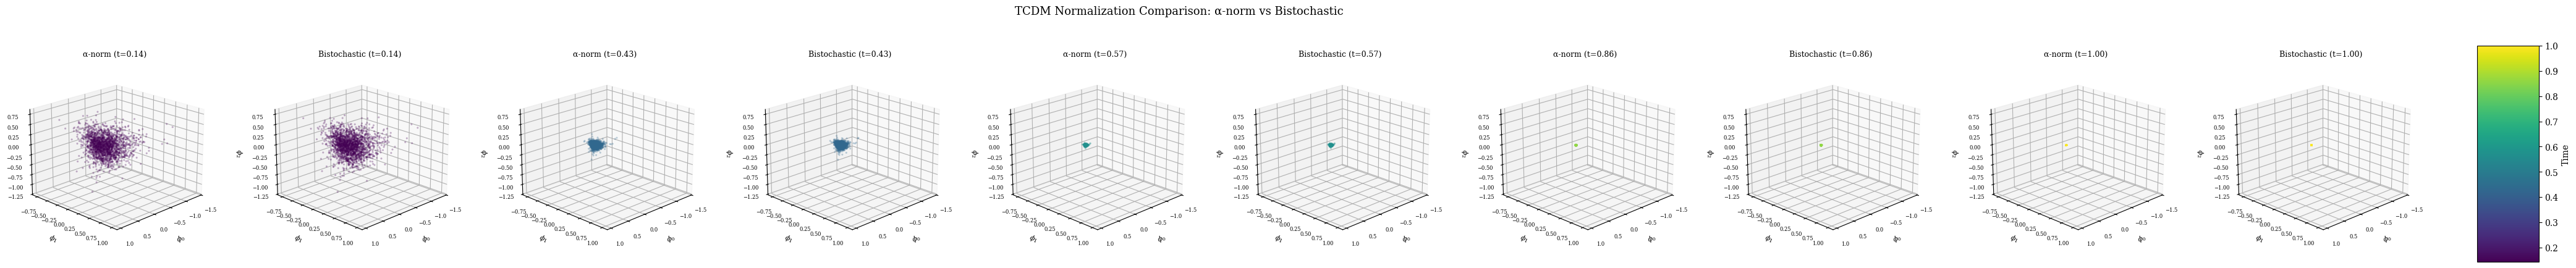

In [6]:
if bistochastic_available:
    fig = compare_embeddings_3d(
        alpha_embeddings,
        bistochastic_embeddings,
        times_alpha,
        n_samples=2000,
        dims=(0, 1, 2),
        save_path=path_root / "figures/tcdm_normalization_comparison.png"
    )
    plt.show()

# %% [markdown]
# ## Distribution Analysis

In [7]:
def analyze_distributions(alpha_emb, bistochastic_emb, times):
    """Compare statistical properties of both embeddings."""
    T, N, D = alpha_emb.shape

    print("\n" + "="*70)
    print("DISTRIBUTION ANALYSIS")
    print("="*70)

    for t_idx in range(T):
        t_val = times[t_idx]
        alpha_t = alpha_emb[t_idx]
        bist_t = bistochastic_emb[t_idx]

        print(f"\nTime t={t_val:.3f}:")
        print(f"  {'Metric':<25} {'α-normalized':<20} {'Bistochastic':<20}")
        print(f"  {'-'*65}")

        # Mean
        alpha_mean = alpha_t.mean()
        bist_mean = bist_t.mean()
        print(f"  {'Global mean':<25} {alpha_mean:>19.6f} {bist_mean:>19.6f}")

        # Std
        alpha_std = alpha_t.std()
        bist_std = bist_t.std()
        print(f"  {'Global std':<25} {alpha_std:>19.6f} {bist_std:>19.6f}")

        # L2 norm (magnitude)
        alpha_norm = np.linalg.norm(alpha_t, 'fro')
        bist_norm = np.linalg.norm(bist_t, 'fro')
        print(f"  {'Frobenius norm':<25} {alpha_norm:>19.6f} {bist_norm:>19.6f}")

        # Sample-wise statistics
        alpha_sample_norms = np.linalg.norm(alpha_t, axis=1)
        bist_sample_norms = np.linalg.norm(bist_t, axis=1)
        print(f"  {'Sample norm (mean)':<25} {alpha_sample_norms.mean():>19.6f} {bist_sample_norms.mean():>19.6f}")
        print(f"  {'Sample norm (std)':<25} {alpha_sample_norms.std():>19.6f} {bist_sample_norms.std():>19.6f}")

In [8]:
if bistochastic_available:
    analyze_distributions(alpha_embeddings, bistochastic_embeddings, times_alpha)

# %% [markdown]
# ## Difference Analysis


DISTRIBUTION ANALYSIS

Time t=0.143:
  Metric                    α-normalized         Bistochastic        
  -----------------------------------------------------------------
  Global mean                          0.000003           -0.000000
  Global std                           0.037965            0.037679
  Frobenius norm                      99.942388           99.190705
  Sample norm (mean)                   1.356531            1.347537
  Sample norm (std)                    0.396889            0.389747

Time t=0.429:
  Metric                    α-normalized         Bistochastic        
  -----------------------------------------------------------------
  Global mean                          0.000001           -0.000000
  Global std                           0.004682            0.004525
  Frobenius norm                      12.325543           11.912710
  Sample norm (mean)                   0.165337            0.160697
  Sample norm (std)                    0.055204            

In [9]:
def analyze_differences(alpha_emb, bistochastic_emb, times):
    """Compute point-wise and global differences."""
    T, N, D = alpha_emb.shape

    print("\n" + "="*70)
    print("DIFFERENCE ANALYSIS")
    print("="*70)

    for t_idx in range(T):
        t_val = times[t_idx]
        alpha_t = alpha_emb[t_idx]
        bist_t = bistochastic_emb[t_idx]

        # Point-wise difference
        diff = alpha_t - bist_t
        diff_norm = np.linalg.norm(diff, axis=1)

        print(f"\nTime t={t_val:.3f}:")
        print(f"  L2 distance (mean):  {diff_norm.mean():.6f}")
        print(f"  L2 distance (std):   {diff_norm.std():.6f}")
        print(f"  L2 distance (min):   {diff_norm.min():.6f}")
        print(f"  L2 distance (max):   {diff_norm.max():.6f}")

        # Global difference
        global_diff = np.linalg.norm(alpha_t - bist_t, 'fro') / np.linalg.norm(alpha_t, 'fro')
        print(f"  Relative Frobenius:  {global_diff:.6f}")

In [10]:
if bistochastic_available:
    analyze_differences(alpha_embeddings, bistochastic_embeddings, times_alpha)

# %% [markdown]
# ## Metadata Comparison


DIFFERENCE ANALYSIS

Time t=0.143:
  L2 distance (mean):  1.346377
  L2 distance (std):   0.517921
  L2 distance (min):   0.599490
  L2 distance (max):   5.692175
  Relative Frobenius:  1.020631

Time t=0.429:
  L2 distance (mean):  0.068615
  L2 distance (std):   0.028970
  L2 distance (min):   0.033582
  L2 distance (max):   0.680803
  Relative Frobenius:  0.427289

Time t=0.571:
  L2 distance (mean):  0.006938
  L2 distance (std):   0.002940
  L2 distance (min):   0.003500
  L2 distance (max):   0.095920
  Relative Frobenius:  0.222970

Time t=0.857:
  L2 distance (mean):  0.004028
  L2 distance (std):   0.002762
  L2 distance (min):   0.000577
  L2 distance (max):   0.027692
  Relative Frobenius:  0.532133

Time t=1.000:
  L2 distance (mean):  0.000497
  L2 distance (std):   0.000208
  L2 distance (min):   0.000071
  L2 distance (max):   0.001489
  Relative Frobenius:  0.168221


In [11]:
if bistochastic_available:
    print("\n" + "="*70)
    print("METADATA COMPARISON")
    print("="*70)

    print("\nα-normalized parameters:")
    for key in ['tc_alpha', 'tc_beta', 'tc_k', 'tc_epsilon_scales_min']:
        if key in alpha_meta:
            print(f"  {key}: {alpha_meta[key]}")

    print("\nBistochastic parameters:")
    for key in ['tc_beta', 'tc_k', 'sinkhorn_max_iter', 'sinkhorn_tol']:
        if key in bistochastic_meta:
            print(f"  {key}: {bistochastic_meta[key]}")

    print("\nCommon metadata:")
    for key in ['data_path', 'test_size', 'seed']:
        alpha_val = alpha_meta.get(key, "N/A")
        bist_val = bistochastic_meta.get(key, "N/A")
        match = "✓" if alpha_val == bist_val else "✗"
        print(f"  {key}: {alpha_val} ({match})")


METADATA COMPARISON

α-normalized parameters:
  tc_alpha: 1.0
  tc_beta: -0.2
  tc_k: 1386
  tc_epsilon_scales_min: 0.01

Bistochastic parameters:
  tc_beta: -0.2
  tc_k: 1386
  sinkhorn_max_iter: 1000
  sinkhorn_tol: 1e-06

Common metadata:
  data_path: /data1/jy384/research/MMSFM/data/tran_inclusions_unscaled_9999.npz (✓)
  test_size: 0.2 (✓)
  seed: 42 (✓)


In [12]:
print("\nAnalysis complete!")



Analysis complete!
